In [1]:
import pickle
with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
    
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
sample_data['Eddy2377'].keys()

dict_keys(['U', 'V', 'TA', 'CS', 'OW', 'VG', 'LNAM', 'COW', 'SSIM'])

In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x.data/1000, y.data/1000
    
def rotate_20_clockwise(x, y):
    theta = np.deg2rad(20)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

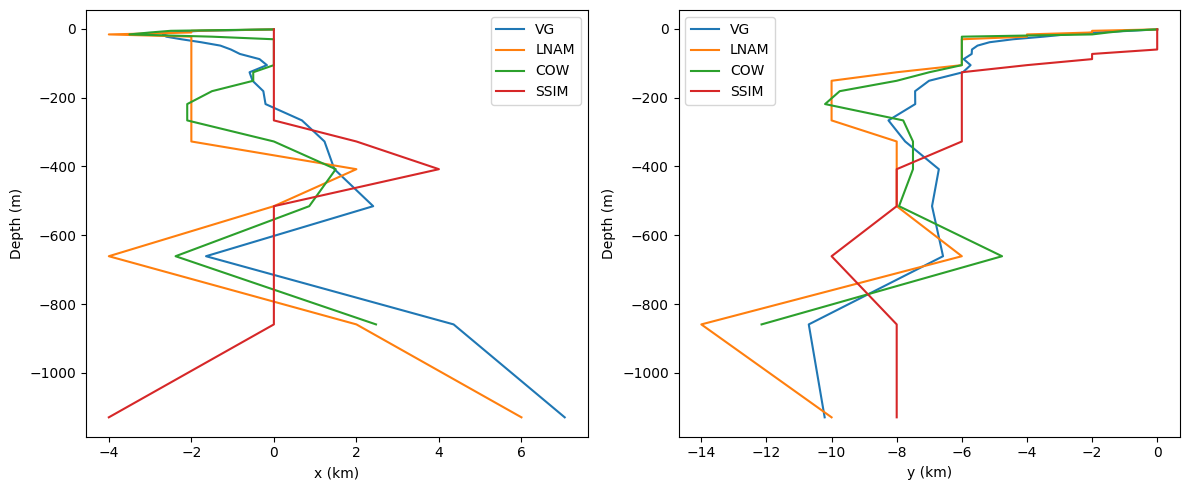

In [6]:
eddy = 'Eddy2377'

t = 0

t0 = eddies[eddy].shape[0] // 2 - 15
t_eddy_relative = t + t0
edata = eddies[eddy].iloc[t_eddy_relative]
i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

VG_time_data = sample_data[eddy]['VG']['T'+str(t)]
LNAM_time_data = sample_data[eddy]['LNAM']['T'+str(t)]
COW_time_data = sample_data[eddy]['COW']['T'+str(t)]
SSIM_time_data = sample_data[eddy]['SSIM']['T'+str(t)]

axs[0].plot(VG_time_data['x'] - VG_time_data.iloc[0]['x'], VG_time_data['Depth'])
axs[0].plot(LNAM_time_data['x'] - LNAM_time_data.iloc[0]['x'], LNAM_time_data['Depth'])
axs[0].plot(COW_time_data['x'] - COW_time_data.iloc[0]['x'], COW_time_data['Depth'])
axs[0].plot(SSIM_time_data['x'] - SSIM_time_data.iloc[0]['x'], SSIM_time_data['Depth'])
axs[0].legend(['VG', 'LNAM', 'COW', 'SSIM'])
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(VG_time_data['y'] - VG_time_data.iloc[0]['y'], VG_time_data['Depth'])
axs[1].plot(LNAM_time_data['y'] - LNAM_time_data.iloc[0]['y'], LNAM_time_data['Depth'])
axs[1].plot(COW_time_data['y'] - COW_time_data.iloc[0]['y'], COW_time_data['Depth'])
axs[1].plot(SSIM_time_data['y'] - SSIM_time_data.iloc[0]['y'], SSIM_time_data['Depth'])
axs[1].legend(['VG', 'LNAM', 'COW', 'SSIM'])
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()



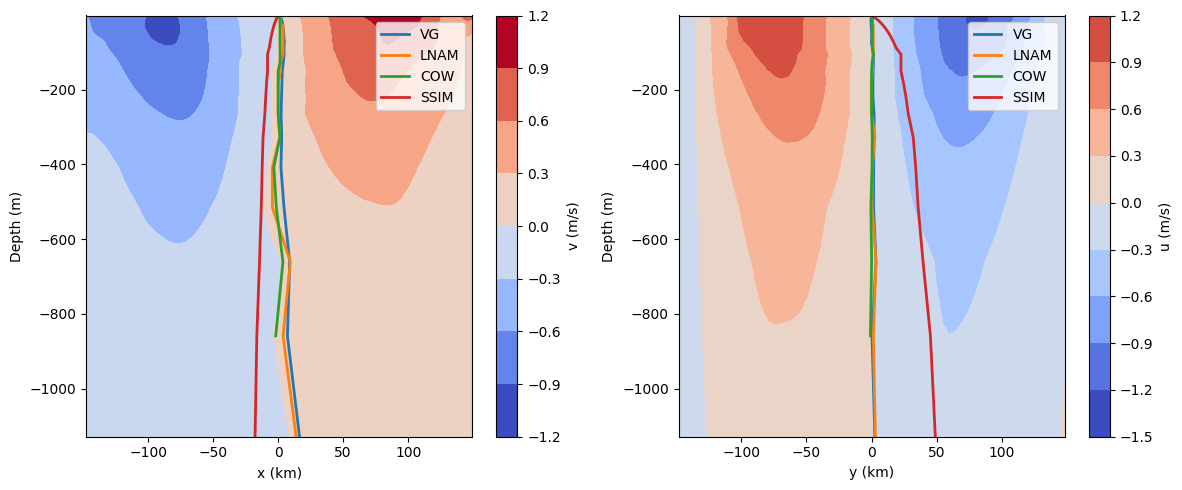

In [17]:
eddy = 'Eddy2377'

t = 5
DISPLAY_WIDTH = 300000
DEPTH_LVL_LIMIT = 23

t0 = eddies[eddy].shape[0] // 2 - 15
t_eddy_relative = t + t0
edata = eddies[eddy].iloc[t_eddy_relative]
i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)

U = sample_data[eddy]['U']
V = sample_data[eddy]['V']

VG_time_data = sample_data[eddy]['VG']['T'+str(t)]
LNAM_time_data = sample_data[eddy]['LNAM']['T'+str(t)]
COW_time_data = sample_data[eddy]['COW']['T'+str(t)]

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

VG_xc, VG_yc, VG_zc = *rotate_20_clockwise(VG_time_data['x'] - VG_time_data.iloc[0]['x'], VG_time_data['y'] - VG_time_data.iloc[0]['y']), VG_time_data['Depth']
LNAM_xc, LNAM_yc, LNAM_zc = *rotate_20_clockwise(LNAM_time_data['x'] - LNAM_time_data.iloc[0]['x'], LNAM_time_data['y'] - LNAM_time_data.iloc[0]['y']), LNAM_time_data['Depth']
COW_xc, COW_yc, COW_zc = *rotate_20_clockwise(COW_time_data['x'] - COW_time_data.iloc[0]['x'], COW_time_data['y'] - COW_time_data.iloc[0]['y']), COW_time_data['Depth']
SSIM_xc, SSIM_yc, SSIM_zc = *rotate_20_clockwise(SSIM_time_data['x'] - SSIM_time_data.iloc[0]['x'], SSIM_time_data['y'] - SSIM_time_data.iloc[0]['y']), SSIM_time_data['Depth']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
v_cross = V[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
c1 = axs[0].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].plot(VG_xc, VG_zc, '-', linewidth=2)
axs[0].plot(LNAM_xc, LNAM_zc, '-', linewidth=2)
axs[0].plot(COW_xc, COW_zc, '-', linewidth=2)
axs[0].plot(SSIM_xc, SSIM_zc, '-', linewidth=2)
axs[0].legend(['VG', 'LNAM', 'COW', 'SSIM'])
fig.colorbar(c1, ax=axs[0], label='v (m/s)')
# axs[0].set_title('LNAM Method Results along x-axis')

# Second subplot
u_cross = U[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
c2 = axs[1].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].plot(VG_yc, VG_zc, '-', linewidth=2)
axs[1].plot(LNAM_yc, LNAM_zc, '-', linewidth=2)
axs[1].plot(COW_yc, COW_zc, '-', linewidth=2)
axs[1].plot(SSIM_yc, SSIM_zc, '-', linewidth=2)
axs[1].legend(['VG', 'LNAM', 'COW', 'SSIM'])
fig.colorbar(c2, ax=axs[1], label='u (m/s)')
# axs[1].set_title('LNAM Method Results along y-axis')

plt.tight_layout()
plt.show()

In [10]:
eddy_path

,Lon,Lat,Vort,Id,Age
Day1531,152.068410,-37.119854,0.000031,2377.0,173
Day1532,152.085357,-37.077505,0.000031,2377.0,173
Day1533,152.054230,-37.068466,0.000032,2377.0,173
Day1534,151.975849,-37.092988,0.000030,2377.0,173
Day1535,151.958844,-37.135337,0.000032,2377.0,173
Day1536,151.989424,-37.144209,0.000032,2377.0,173
Day1537,151.958844,-37.135337,0.000032,2377.0,173
Day1538,151.928554,-37.126548,0.000031,2377.0,173
Day1539,151.881510,-37.160191,0.000031,2377.0,173
Day1540,151.864459,-37.202540,0.000033,2377.0,173


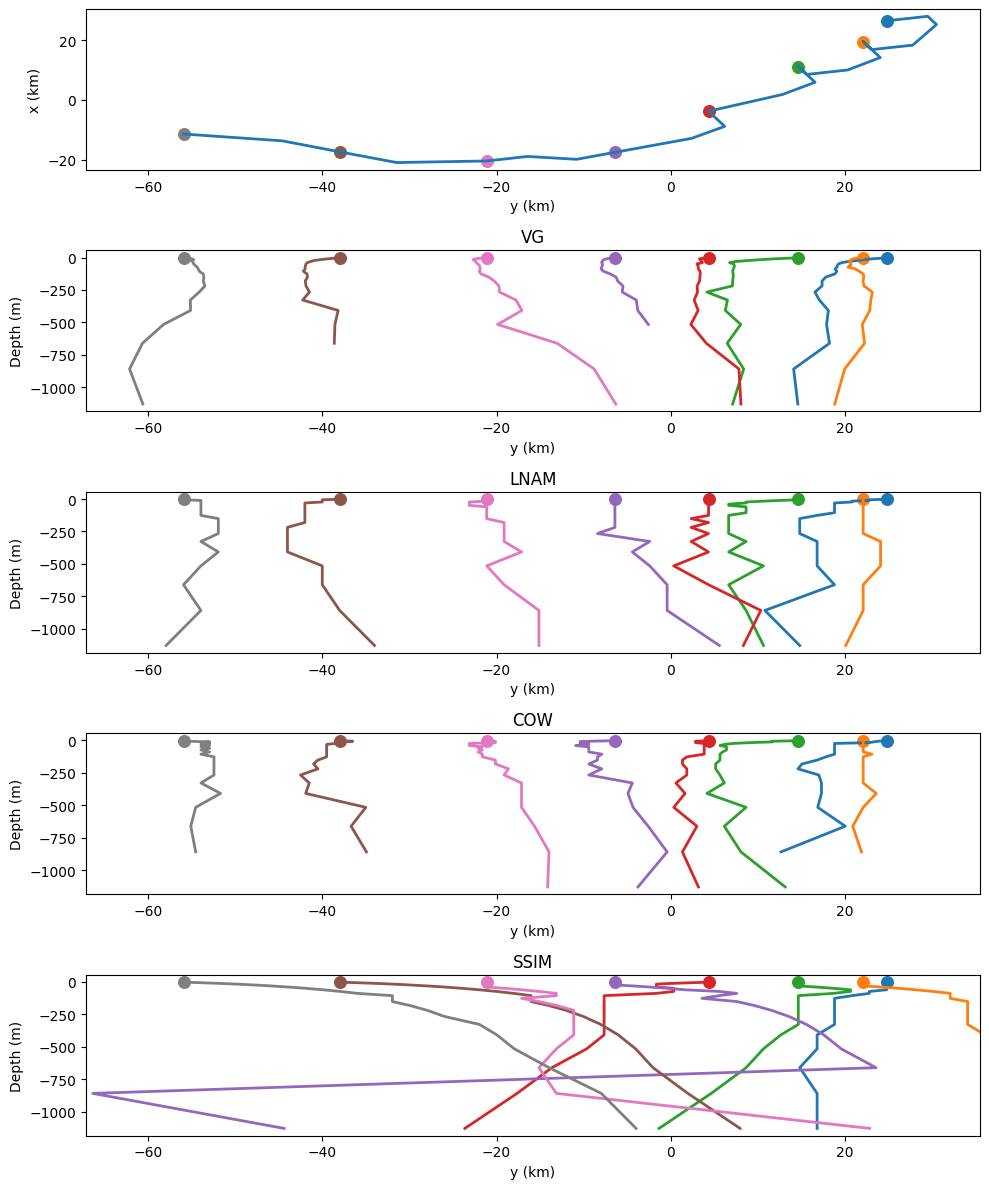

In [15]:
fig, axs = plt.subplots(5, 1, figsize=(10, 12))

edata = eddies[eddy].iloc[eddies[eddy].shape[0] // 2 - 15:eddies[eddy].shape[0] // 2 + 15]
x, y = make_cartesian(edata.Lon, edata.Lat, edata.Lon.mean(), edata.Lat.mean())
eddy_path = pd.DataFrame({'x': x, 'y': y})

# Initialize variables to track the global min and max for y
y_min = float('inf')
y_max = float('-inf')

# First loop to calculate the y-axis limits
for t in list(range(0, 30, 5)) + [29]:
    VG_time_data = sample_data[eddy]['VG']['T'+str(t)]
    LNAM_time_data = sample_data[eddy]['LNAM']['T'+str(t)]
    COW_time_data = sample_data[eddy]['COW']['T'+str(t)]

    # Adjust y values for each time step
    y_VG = VG_time_data['y'] - VG_time_data.iloc[0]['y'] + eddy_path.iloc[t].y
    y_LNAM = LNAM_time_data['y'] - LNAM_time_data.iloc[0]['y'] + eddy_path.iloc[t].y
    y_COW = COW_time_data['y'] - COW_time_data.iloc[0]['y'] + eddy_path.iloc[t].y

    # Update y_min and y_max
    y_min = min(y_min, y_VG.min(), y_LNAM.min(), y_COW.min(), eddy_path['y'].min())
    y_max = max(y_max, y_VG.max(), y_LNAM.max(), y_COW.max(), eddy_path['y'].max())
y_min -= 5
y_max += 5

# Plot the eddy path
axs[0].plot(eddy_path['y'], eddy_path['x'], linewidth=2)
axs[0].set_xlabel('y (km)')
axs[0].set_ylabel('x (km)')
axs[0].set_xlim([y_min, y_max])
# axs[0].axis('equal')

# Second loop to plot the data and apply consistent x-axis limits
for t in list(range(0, 30, 5)) + [23, 29]:
    axs[0].scatter(eddy_path.iloc[t]['y'], eddy_path.iloc[t]['x'], s=70)

    VG_time_data = sample_data[eddy]['VG']['T'+str(t)]
    LNAM_time_data = sample_data[eddy]['LNAM']['T'+str(t)]
    COW_time_data = sample_data[eddy]['COW']['T'+str(t)]
    SSIM_time_data = sample_data[eddy]['SSIM']['T'+str(t)]

    y = VG_time_data['y'] - VG_time_data.iloc[0]['y'] + eddy_path.iloc[t].y
    z = VG_time_data['Depth']
    axs[1].plot(y, z, linewidth=2)
    axs[1].scatter(y[0], z[0], s=70)
    axs[1].set_xlim([y_min, y_max])  
    axs[1].set_title('VG')
    axs[1].set_xlabel('y (km)')
    axs[1].set_ylabel('Depth (m)')

    y = LNAM_time_data['y'] - LNAM_time_data.iloc[0]['y'] + eddy_path.iloc[t].y
    z = LNAM_time_data['Depth']
    axs[2].plot(y, z, linewidth=2)
    axs[2].scatter(y[0], z[0], s=70)
    axs[2].set_xlim([y_min, y_max])  
    axs[2].set_title('LNAM')
    axs[2].set_xlabel('y (km)')
    axs[2].set_ylabel('Depth (m)')

    y = COW_time_data['y'] - COW_time_data.iloc[0]['y'] + eddy_path.iloc[t].y
    z = COW_time_data['Depth']
    axs[3].plot(y, z, linewidth=2)
    axs[3].scatter(y[0], z[0], s=70)
    axs[3].set_xlim([y_min, y_max])  
    axs[3].set_title('COW')
    axs[3].set_xlabel('y (km)')
    axs[3].set_ylabel('Depth (m)')

    y = SSIM_time_data['y'] - SSIM_time_data.iloc[0]['y'] + eddy_path.iloc[t].y
    z = SSIM_time_data['Depth']
    axs[4].plot(y, z, linewidth=2)
    axs[4].scatter(y[0], z[0], s=70)
    axs[4].set_xlim([y_min, y_max])  
    axs[4].set_title('SSIM')
    axs[4].set_xlabel('y (km)')
    axs[4].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()
